In [14]:
from sklearn import datasets
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score
from autocluster.autohypothesis import autohypothesis_utils
import optuna
import numpy as np

In [15]:
sk_iris = datasets.load_iris()
iris = pd.DataFrame(sk_iris['data'], columns=sk_iris['feature_names'])
iris['target'] = sk_iris['target']
sk_wine = datasets.load_wine()
wine = pd.DataFrame(sk_wine['data'], columns=sk_wine['feature_names'])
wine['target'] = sk_wine['target']
star_df = pd.read_csv('star_classification.csv')
star_df.rename(columns={"class": "target"}, inplace=True)
star_df.drop(columns=['obj_ID',"fiber_ID","run_ID","rerun_ID","field_ID","spec_obj_ID","fiber_ID"], inplace=True)
_, star_df = train_test_split(star_df, test_size=0.05, stratify=star_df['target'], random_state=42)
synthetic_df = autohypothesis_utils.create_dataset(n=10, k=500, c=3, b=4)

In [16]:
exp,X_train, X_dev, y_train, y_dev  = autohypothesis_utils.opti_loop(iris,50, optimize_obj="dual")


[I 2023-11-29 13:50:24,605] A new study created in memory with name: no-name-fc28c205-26fd-429a-bffc-33c974ea3ea3
[I 2023-11-29 13:50:24,904] Trial 0 finished with values: [0.9111111111111111, 0.2324722183993284] and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 305, 'rf_max_depth': 29, 'rf_min_samples_split': 0.3721079545081649, 'rf_min_samples_leaf': 0.21164824558681797, 'rf_max_features': 'sqrt', 'rf_random_state': 42}. 
[I 2023-11-29 13:50:25,390] Trial 1 finished with values: [0.9777777777777777, 0.2531017322433867] and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 588, 'rf_max_depth': 3, 'rf_min_samples_split': 0.48737753740029655, 'rf_min_samples_leaf': 0.1611762946177318, 'rf_max_features': 'sqrt', 'rf_random_state': 42}. 
[I 2023-11-29 13:50:25,825] Trial 2 finished with values: [0.3333333333333333, 0.0] and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 536, 'rf_max_depth': 3, 'rf_min_samples_split': 0.15764409858487333, 'rf_min_

In [31]:
fig = optuna.visualization.plot_pareto_front(exp, target_names=["Accuracy", "Entropie"], include_dominated_trials=False)
#fig = optuna.visualization.plot_pareto_front(motpe_experiment, target_names=["objective 1", "objective 2"])
fig.layout.title = 'Pareto-front MOTPE'
fig

In [18]:
all_objectives = np.array([trial.values for trial in exp.best_trials ])
sorted_objectives = all_objectives[np.argsort(all_objectives[:, 0])]
all_objectives

array([[0.95555556, 0.27028581],
       [0.93333333, 0.31879464],
       [0.97777778, 0.2569305 ]])

In [19]:
exp.best_trials

[FrozenTrial(number=3, state=TrialState.COMPLETE, values=[0.9555555555555556, 0.27028580637025534], datetime_start=datetime.datetime(2023, 11, 29, 13, 50, 25, 826536), datetime_complete=datetime.datetime(2023, 11, 29, 13, 50, 26, 425726), params={'classifier': 'RandomForest', 'rf_n_estimators': 726, 'rf_max_depth': 2, 'rf_min_samples_split': 0.42567343642956357, 'rf_min_samples_leaf': 0.10385334940610767, 'rf_max_features': 'log2', 'rf_random_state': 42}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'classifier': CategoricalDistribution(choices=('RandomForest',)), 'rf_n_estimators': IntDistribution(high=1000, log=False, low=10, step=1), 'rf_max_depth': IntDistribution(high=32, log=True, low=2, step=1), 'rf_min_samples_split': FloatDistribution(high=1.0, log=False, low=0.1, step=None), 'rf_min_samples_leaf': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'rf_max_features': CategoricalDistribution(choices=('sqrt', 'log2')), 'rf_random_state': IntDis

In [20]:
data = []
for trial in exp.best_trials:
    # Here, we assume that `values` contains [accuracy, entropy] in that order
    accuracy, entropy = (round(val, 3) for val in trial.values) if trial.values else (None, None)
    data.append({
        'number': trial.number,
        'accuracy': accuracy,
        'entropy': 1-entropy,
        'params': trial.params
    })

#Convert Dictionary List to a DataFrame
df = pd.DataFrame(data)
df.to_csv("opti_duo.csv")

In [21]:
params = autohypothesis_utils.get_trial_hyperparams(exp, trial_number=10) #61 #126
pipeline = autohypothesis_utils.rebuild_pipeline_with_hyperparams(params)
pipeline.fit(X_train, y_train)
acc = accuracy_score(y_dev, pipeline.predict(X_dev))
entropy = autohypothesis_utils.clusterEntropy(pipeline, X_dev, pipeline.predict(X_dev))
print(f"Accuracy: {acc:.4f} - Entropy: {1-entropy:.4f}")

Accuracy: 0.6667 - Entropy: 0.6867


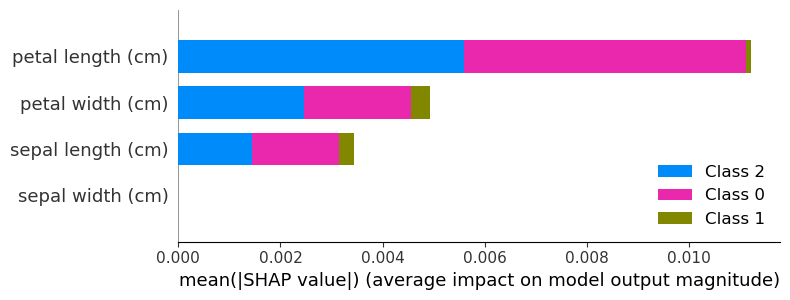

In [22]:
import shap

# Initialize your explainer
explainer = shap.Explainer(pipeline.named_steps['classifier'])

# Compute SHAP values
shap_values = explainer.shap_values(X_dev)

# Summarize the SHAP values in a plot
shap.summary_plot(shap_values, X_dev)


In [23]:
vect = np.mean(np.abs(shap_values[1]), axis=0) 
I_c_minmax = (vect - np.min(vect)) / (np.max(vect) - np.min(vect))
sum_I_c_minmax = np.sum(I_c_minmax)
I_c_normalized = I_c_minmax / sum_I_c_minmax

In [24]:
import numpy as np

unique_classes = np.unique(y_dev)
random_ids = {}

for cls in unique_classes:
    # Get indices of all instances of this class
    class_indices = np.where(y_dev == cls)[0]
    # Randomly select an indice from these indices
    random_id = np.random.choice(class_indices)
    random_ids[cls] = random_id

print(random_ids)


{0: 41, 1: 28, 2: 2}


In [25]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][random_ids[0]], X_dev.iloc[random_ids[0]])


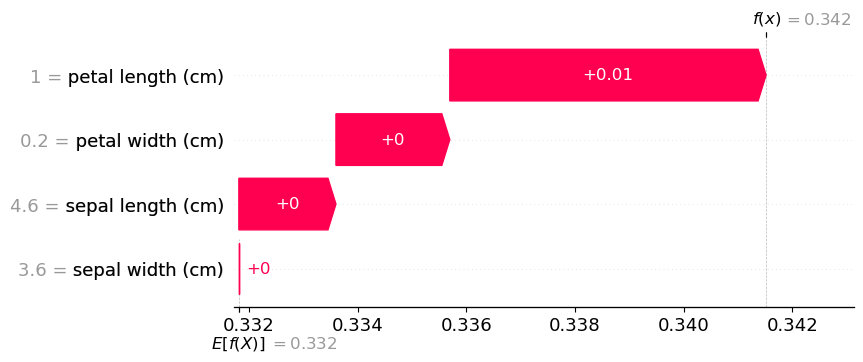

In [26]:
row = random_ids[0]
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
                                              base_values=explainer.expected_value[0], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))

In [27]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][random_ids[1]], X_dev.iloc[random_ids[1]])

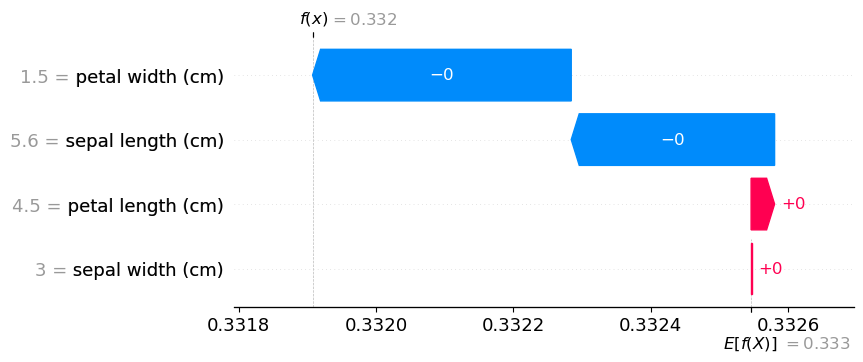

In [28]:
row = random_ids[1]
shap.waterfall_plot(shap.Explanation(values=shap_values[1][row], 
                                              base_values=explainer.expected_value[1], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))

In [29]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][random_ids[2]], X_dev.iloc[random_ids[2]])

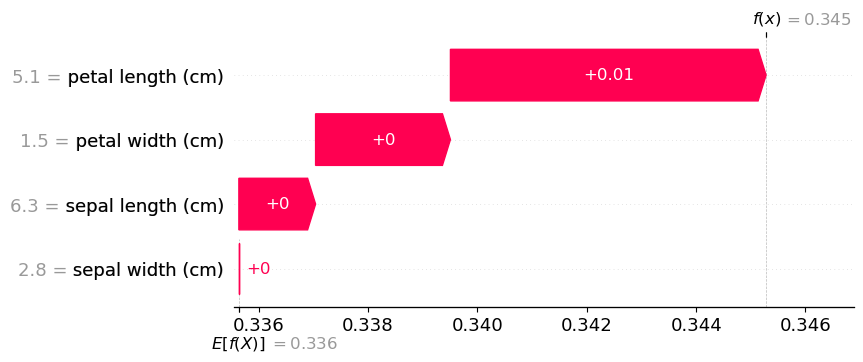

In [30]:
row = random_ids[2]
shap.waterfall_plot(shap.Explanation(values=shap_values[2][row],
                                              base_values=explainer.expected_value[2], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))